# <font color='blue'> Table Of Contents </font>

### <font color='blue'> How to use CI/CD to deploy and configure AWS security services with Terraform </font>

### <font color='blue'> Sennder: AWS multi-account CI/CD with Gitlab runners </font>

### <font color='blue'> Gruntwork: Comparing And Contrasting Several Infrastructure As Code (IaC) </font>

# <font color='blue'> How to use CI/CD to deploy and configure AWS security services with Terraform </font>

Like the infrastructure your applications are built on, security infrastructure can be handled using **Infrastructure as Code** (**IaC**) and Continuous Integration/Continuous Deployment (**CI/CD**).

In this solution, we will use **Terraform** configuration files to build a **WAF**, deploy it automatically through a **CI/CD pipeline**, and retain the WAF state files to be later referenced, changed, or destroyed through subsequent deployments in a durable backend.

**CodePipeline** helps us automate our release pipeline through build, test, and deployment.

The source stage uses **AWS CodeCommit**, which is the AWS fully-managed managed, Git-based source code management service that can be interacted with via the console and CLI.

For the build stage, we use **AWS CodeBuild**, which is a fully managed CI service that compiles source code, runs tests, and produces software packages that are ready to deploy.

Finally, e will create a new **Amazon Simple Storage Service** (**S3**) bucket and an **Amazon DynamoDB** table to durably store the Terraform state files outside of the CI/CD pipeline.

For the purpose of this post, the security infrastructure resource deployed through the pipeline will be an **AWS WAF**, specifically a **Global Web ACL** that can attach to an **Amazon CloudFront** distribution, with a sample **SQL Injection and Blacklist** filtering rule.

Here is a schematic of the deployment infrastructure:

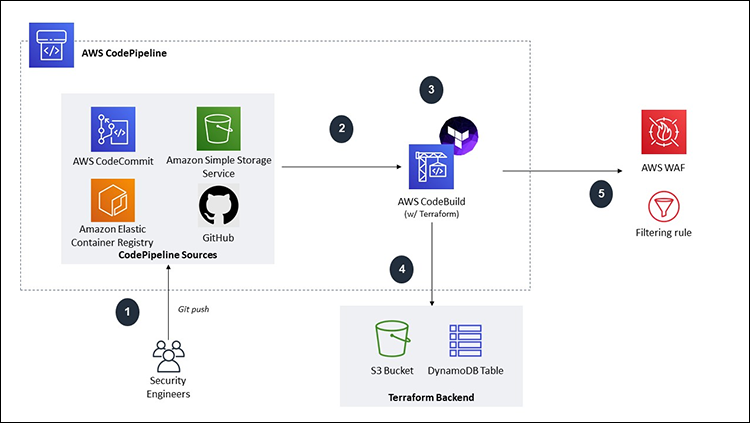
The steps involved are as follows:

* Push artifacts, **Terraform** configuration files and a build specification to a **CodePipeline** source.
* **CodePipeline** automatically invokes **CodeBuild** and downloads the source files.
* **CodeBuild** installs and executes Terraform according to a build specification.
* **Terraform** stores the state files in **S3** and a record of the deployment in **DynamoDB**.
* The **WAF Web ACL** is deployed and ready for use by application teams.

With all permissions and supporting infrastructure set up, we can now deploy the WAF. Navigate to this GitHub repository and clone it - there are five files we need:

* provider.tf
* variables.tf
* waf-conditions.tf
* waf-rules.tf
* buildspec.yaml

Each of these files can be viewed in the reference links provided below.

The Terraform template ```provider.tf``` is edited as follows:

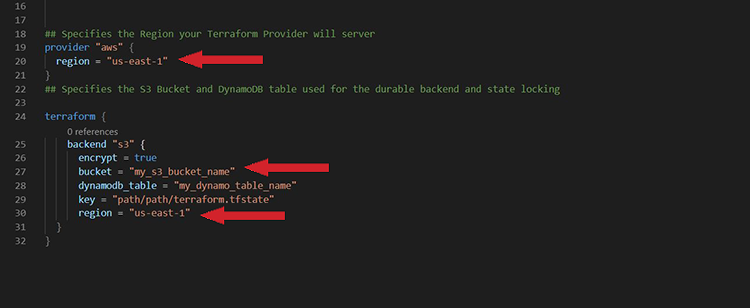

Using the Console, we upload all five files downloaded from GitHub. Alternatively, one can learn how to do this using the CLI in the AWS CodeCommit User Guide.

After uploading all the files, navigate to the **CodePipeline** console and start the pipeline.

Choose ```Tail Logs``` to view logs in near real-time from the **CodeBuild** environment. One can see the output from **Terraform**, as well as other information, such as errors and environmental logs, from the **CodeBuild** service. 

This view can be useful for debugging missing permissions for Terraform, as it will cause a failure and **Terraform** will log what IAM permissions were denied.

After a successful deployment, we can navigate to the **AWS WAF Web ACL Console**, and then choose the **Web ACL** that was deployed. From here, we can associate the **Global Web ACL** with a **CloudFront** distribution to test the efficacy.

## <font color='blue'> References </font>

1. How to use CI/CD to deploy and configure AWS security services with Terraform: AWS Security Blog - [https://aws.amazon.com/blogs/security/how-use-ci-cd-deploy-configure-aws-security-services-terraform/](https://aws.amazon.com/blogs/security/how-use-ci-cd-deploy-configure-aws-security-services-terraform/)
2. Image: AWS Security Configurations Using Terraform - [https://d2908q01vomqb2.cloudfront.net/22d200f8670dbdb3e253a90eee5098477c95c23d/2019/11/19/DevSecOps-Figure1.png](https://d2908q01vomqb2.cloudfront.net/22d200f8670dbdb3e253a90eee5098477c95c23d/2019/11/19/DevSecOps-Figure1.png)

# <font color='blue'> Sennder: AWS multi-account CI/CD with Gitlab runners </font>

**SennCloud** is the new cloud infrastructure framework for **Sennder**’s product engineering. It is a clean, newly-built cloud-native ecosystem for the development and evolution of microservices on top of **Amazon Web Services** (**AWS**).

**SennCloud** maintains individual, separate AWS accounts, paving the way for new security features and new ways of working. Sennder started off its journey with one AWS account, which hosted everything:

* Services
* CI/CD infrastructure
* Access management
* Business intelligence applications

In order to adapt to the business needs and be able to cover the opportunities in the market with innovative solutions, Sennder needed to redefine the way in which software is developed, built, and operated so that it scales.

The platform team re-architected Sennder’s entire cloud infrastructure into **SennCloud**. Multiple AWS accounts boost teams’ productivity levels while scaling and paving the way towards self-service infrastructure.

A new organization setup meant that the existing **Continuous Integration / Continuous Deployment** (**CI/CD**) setup, implemented to work within an individual AWS account, had to be redesigned too. Thus, a multi-account CI/CD system for SennCloud was created.

The platform team at sennder decided to evaluate **AWS Organizations** together with **AWS Control Tower**. **AWS Control Tower** gives Sennder the ability to:

* Roll out AWS accounts on-demand
* Scale fast
* Seamlessly apply policies, enrolling access management
* Maintain centralized control across the whole organization

The **Control Tower** is enabled in the root account, and it creates two AWS accounts: One account for audits and another one for log archives. These two accounts get associated with an organizational unit (**OU**), called the **core OU**.

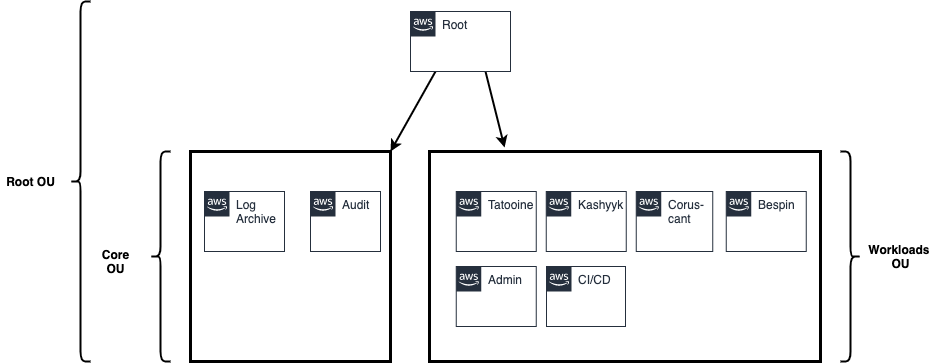

There are numerous questions to answer when creating a new AWS account setup:

* Do AWS accounts represent environments?
* Does each team get its own AWS account?
* How does one monitor the overall setup?
* Who is responsible for maintaining the development environments?
* And most tricky: What is an environment?

An **environment** at Sennder is a collection of services that serve a certain purpose along the software development lifecycle (**SDLC**). When engineers develop their services, they will be able to test their code in a so-called development environment.

For now, engineering at Sennder operates on two accounts that correlate to the previously mentioned environments, **development** and **production**. Both accounts are associated with a separate OU, the so-called **workload OU**. 

Most of the account setup is created with **Terraform**. The **Terraform state** for common **cloud infrastructure** is kept in the **admin** account. **Services** store their own state in the respective **environment** accounts.

With continuous delivery in mind, the platform team at sennder aims for account segregation while keeping the infrastructure setup as close to a productive environment as possible.

To provide a centralized solution for CI/CD, Sennder uses Gitlab CI SaaS to host the codebase and customized runners in **AWS Elastic Kubernetes Service** (**EKS**) to build the software. 

Those runners need to be able to assume roles in the different AWS accounts, push images to **AWS Elastic Container Registries** (**ECR**), deploy software, and register resources in our **AWS API Gateway**. The services are mainly hosted with **AWS Elastic Container Service** (**ECS**).

Since Sennder uses **GitLab** as a **SaaS Git repository manager**, they decided to use **GitLab CI** to set up those pipelines. This approach allows us to store the pipeline definitions alongside the code.

The main goal is to allow the centralized CI/CD infrastructure to deploy infrastructure and applications to different accounts within the organization, as depicted by the diagram below.

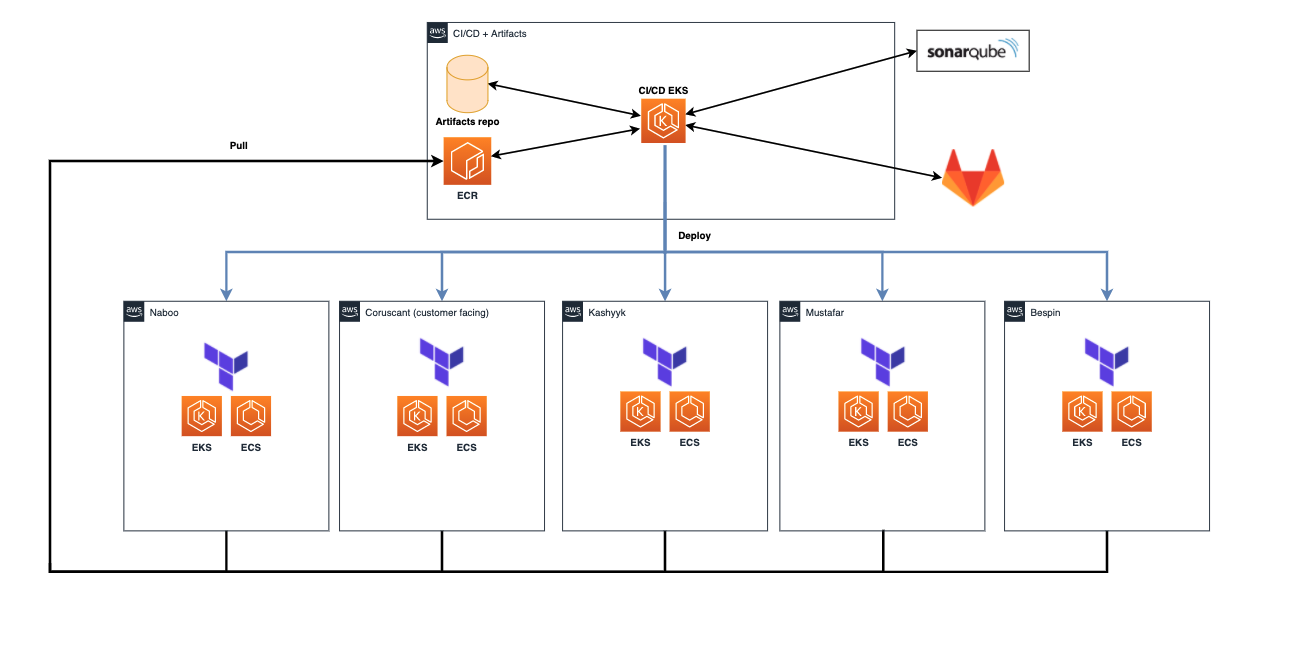

Due to the nature of the different pieces of software ans infrastructure involved, not all the jobs require the same amount of resources from the cluster. So we introduced three types of runners:

* **Small runners**: Intended for lightweight pipelines, mostly based on command-line interfaces (CLIs): ```terraform```, ```kubectl```, ```helm```, ```lint``` processes.
* **Medium runners**: Used for intensive pipelines such as **Docker** image building.
* **Big runners**: Dedicated to extremely intensive workloads such as compilation, webpage rendering, or performance testing.

The **runner type** is selected within a pipeline using tags so developers can customize the different jobs within the pipeline to use the runner that suits the workload best. The following snippet shows a **Terraform job** that relies on **small runners**. Notice how the ```tags:``` directive is used to select the runner.

In [ ]:
image: xxxx.dkr.ecr.eu-central-1.amazonaws.com/platform/docker-base-images/docker-19.03-tf-13:latest
 
.prepare:
 variables:
   PLAN: ${CI_ENVIRONMENT_NAME}.plan.tfplan
   PLAN_JSON: ${CI_ENVIRONMENT_NAME}.tfplan.json
   TF_ROOT: ${CI_PROJECT_DIR}/iac/terraform/app
 before_script:
   - cd ${TF_ROOT}
   - terraform init
 tags:
   - small

The next step was to ensure that the runners could deploy applications and infrastructure into the different accounts that make up SennCloud. This was done by means of **AWS Identity Access Management (IAM) Roles**. Sennder added a **delegated role** in each account to which the **GitLab CI** pipelines would have to deploy, providing the required permissions over the resources to deploy in those accounts.

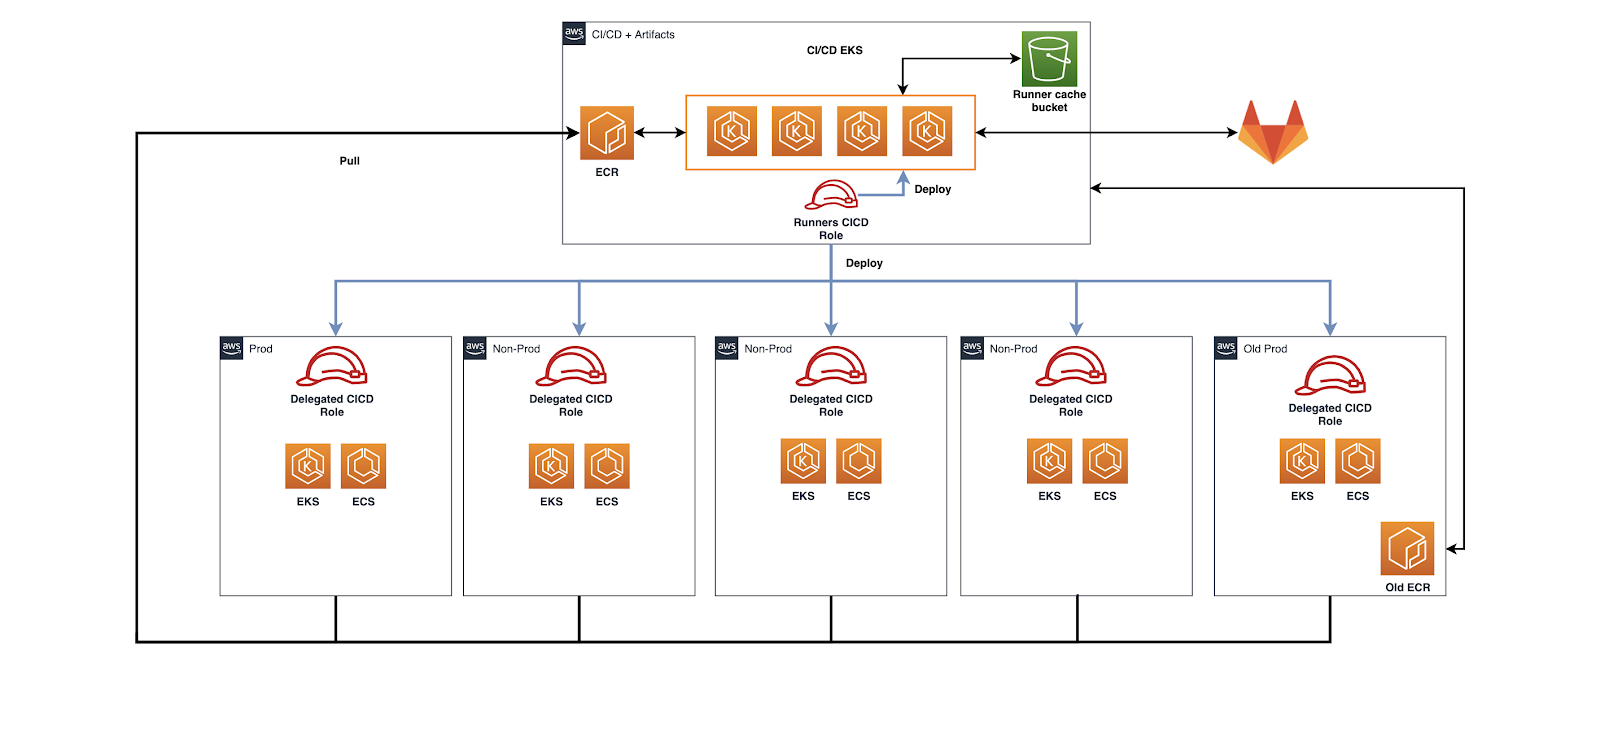

## <font color='blue'> AWS Profiles And Terraform </font>

The infrastructure is provisioned by means of **Terraform**, and it needs to know which **IAM Role** to use when deploying to a specific account. 

**Terraform** handles account switching by means of AWS profiles that can be specified as environment variables or within the **Terraform** code itself. 

The following snippet shows a provider definition that will use the admin profile. Profiles are also specified within the backend configuration so that **Terraform** can access the remote state buckets where it will persist its data.

In [ ]:
provider "aws" {
 region              = var.region
 allowed_account_ids = var.allowed_account_ids
 profile             = "admin"
}

In order to gain experience and confidence in the new platform, one needs rapid feedback loops. This new CI/CD flow supports this because the pipelines can build software in a fast and reliable manner, making it easy for the teams to maneuver. Enhanced observability also supports this approach. 

## <font color='blue'> Future Improvement </font>

One topic still has some work left is the production environments. Isolating production and development environments from each other seems right at first glance, but can definitely be improved. In the near future, Sennder will be working on new solutions to enable teams to maintain their own productive software, paving the way for self-service infrastructure.

## <font color='blue'> References </font>

1. AWS multi-account CI/CD with Gitlab runners: Sennder Blog - [https://www.sennder.com/post/aws-multi-account-ci-cd-with-gitlab-runners](https://www.sennder.com/post/aws-multi-account-ci-cd-with-gitlab-runners)
2. Image: Senndr AWS Account Configuration - [https://miro.medium.com/max/941/0*tcWSlqe5wy4kRdSr](https://miro.medium.com/max/941/0*tcWSlqe5wy4kRdSr)
3. Image: Sennder CI/CD Infrastructure - [https://miro.medium.com/max/1315/0*g_VxUpbffgsNTeeX](https://miro.medium.com/max/1315/0*g_VxUpbffgsNTeeX)
4. Image: Sennder GitLab CI/CD Pieplines - [https://miro.medium.com/max/1600/0*f-zMIGVqFJUhyP4e](https://miro.medium.com/max/1600/0*f-zMIGVqFJUhyP4e)

# <font color='blue'> Gruntwork: Comparing And Contrasting Several Infrastructure As Code (IaC) </font>

If one searchs the Internet for **“infrastructure-as-code”**, it’s pretty easy to come up with a list of the most popular tools:

* Chef
* Puppet
* Ansible
* SaltStack
* CloudFormation
* Terraform

Kindly note the following points: about the above tools:

* All of these tools can be used to manage infrastructure as code. 
* All of them are open source, backed by large communities of contributors, and work with many different cloud providers (with the notable exception of CloudFormation, which is closed source and AWS-only). 
* All of them offer enterprise support. All of them are well documented, both in terms of official documentation and community resources such as blog posts and StackOverflow questions. 

So how does one decide?

As with all technology decisions, it is a question of trade-offs and priorities. While particular priorities may change from team to team, here are the main trade-offs one can consider.

## <font color='blue'> Configuration Management vs Provisioning </font>

**Chef**, **Puppet**, **Ansible**, and **SaltStack** are all **configuration management** tools, designed to install and manage software on existing servers. 

**CloudFormation** and **Terraform** are provisioning tools, designed to provision the servers themselves (as well as the rest of your infrastructure, like load balancers, databases, networking configuration, etc), leaving the job of configuring those servers to other tools. 

## <font color='blue'> Mutable Infrastructure vs Immutable Infrastructure </font>

**Configuration management** tools such as **Chef**, **Puppet**, **Ansible**, and **SaltStack** typically default to a mutable infrastructure paradigm. For example, if one asks **Chef** to install a new version of OpenSSL, it’ll run the software update on your existing servers and the changes will happen in-place. 

Over time, as one applies more updates, each server builds up a unique history of changes. This often leads to a phenomenon known as **configuration drift**, where each server becomes slightly different than all the others, leading to subtle configuration bugs that are difficult to diagnose and nearly impossible to reproduce.

If we use a **provisioning** tool such as **Terraform** to deploy machine images created by Docker or Packer, every “change” is actually a deployment of a new server.

This approach:

* Reduces the likelihood of configuration drift bugs
* Makes it easier to know exactly what software is running on a server
* Allows one to trivially deploy any previous version of the software at any time.

## <font color='blue'> Procedural vs Declarative </font>

**Chef** and **Ansible** encourage a **procedural** style where you write code that specifies, step-by-step, how to to achieve some desired end state. 

* The state of the infrastructure is not fully captured in the code.
* The reusability of procedural code is inherently limited because you have to manually take into account the current state of the codebase. Since that state is constantly changing, procedural code bases tend to grow large and complicated over time.


**Terraform**, **CloudFormation**, **SaltStack**, and **Puppet** all encourage a more declarative style, where one write code that specifies a desired end state, and the IAC tool itself is responsible for figuring out how to achieve that state. 

With declarative code, **Terraform** figures out how to get to that end state, and is also aware of any state it created in the past.

* The code always represents the latest state of your infrastructure. At a glance, you can tell what’s currently deployed and how it’s configured, without having to worry about history or timing. 
* It is easy to create reusable code, as you don’t have to manually account for the current state of the world. Instead, you just focus on describing your desired state, keeping codebases small and easy to understand.
* Without access to a full programming language, your expressive power is limited. For example, some types of infrastructure changes, such as a rolling, zero-downtime deployment, are hard to express in purely declarative terms.

## <font color='blue'> Master Versus Masterless </font>

By default, **Chef**, **Puppet**, and **SaltStack** all require that we run a **master server** to store the state of the infrastructure, and distributing updates. 

Every time one wants to update something in the infrastructure, one uses a client (e.g. a command-line tool) to issue new commands to the master server. The master server either pushes the updates out to all the other servers, or those servers pull the latest updates down from the master server on a regular basis.

However, this approach has some serious drawbacks:

* **Extra infrastructure**: One has to deploy an extra server, or a cluster of extra servers (for high availability and scalability), just to run the master.
* **Maintenance**: One needs to maintain, upgrade, back up, monitor, and scale the master server(s).
* **Security**: One needs to provide a way for the client to communicate to the master server(s), and a way for the master server(s) to communicate with all the other servers. This means opening extra ports and configuring extra authentication systems, which increases the surface area to attackers.

**Ansible**, **CloudFormation**, **Heat**, and **Terraform** are all masterless by default. To be more accurate, some of them may rely on a master server, but that is already part of the infrastructure beign used, and not an extra piece one has to manage. 

For example, **Terraform** communicates with cloud providers using the cloud provider’s APIs. In some sense, the API servers are master servers, except they don’t require any extra infrastructure or any extra authentication mechanisms (i.e., we can just use our API keys).

## <font color='blue'> Agent Versus Agentless </font>

**Chef**, **Puppet**, and **SaltStack** all require one to install agent software (e.g., **Chef Client**, **Puppet Agent**, **Salt Minion**) on each server to configure. The agent typically runs in the background on each server and is responsible for installing the latest configuration management updates.

This has a few drawbacks:

* **Bootstrapping**: How does one provision servers and install the agent software on them in the first place? 
* **Maintenance**: One has to carefully update the agent software on a periodic basis, keeping it in sync with the master server, if there is one.Also, one has to monitor the agent software and restart it, if it crashes.
* **Security**: 
    * If the agent software pulls down configuration from a master server or any external source, one has to open outbound ports on every server. 
    * If the master server pushes configuration to the agent, one needs to open inbound ports on every server. 
    * In either case, we have to figure out how to authenticate the agent to the server it’s talking to. All of this increases your surface area to attackers.

**Ansible**, **CloudFormation**, **Heat**, and **Terraform** do not require us to install any extra agents. True, some of them require agents, but these are typically already installed as part of the infrastructure. 

## <font color='blue'> Large Community vs Small Community </font>

Whenever one picks a technology, one also picks a community. In many cases, the ecosystem around the project can have a bigger impact on our experience than the inherent quality of the technology itself.

The table below shows a comparison of popular IaC tools, circa May 2019:

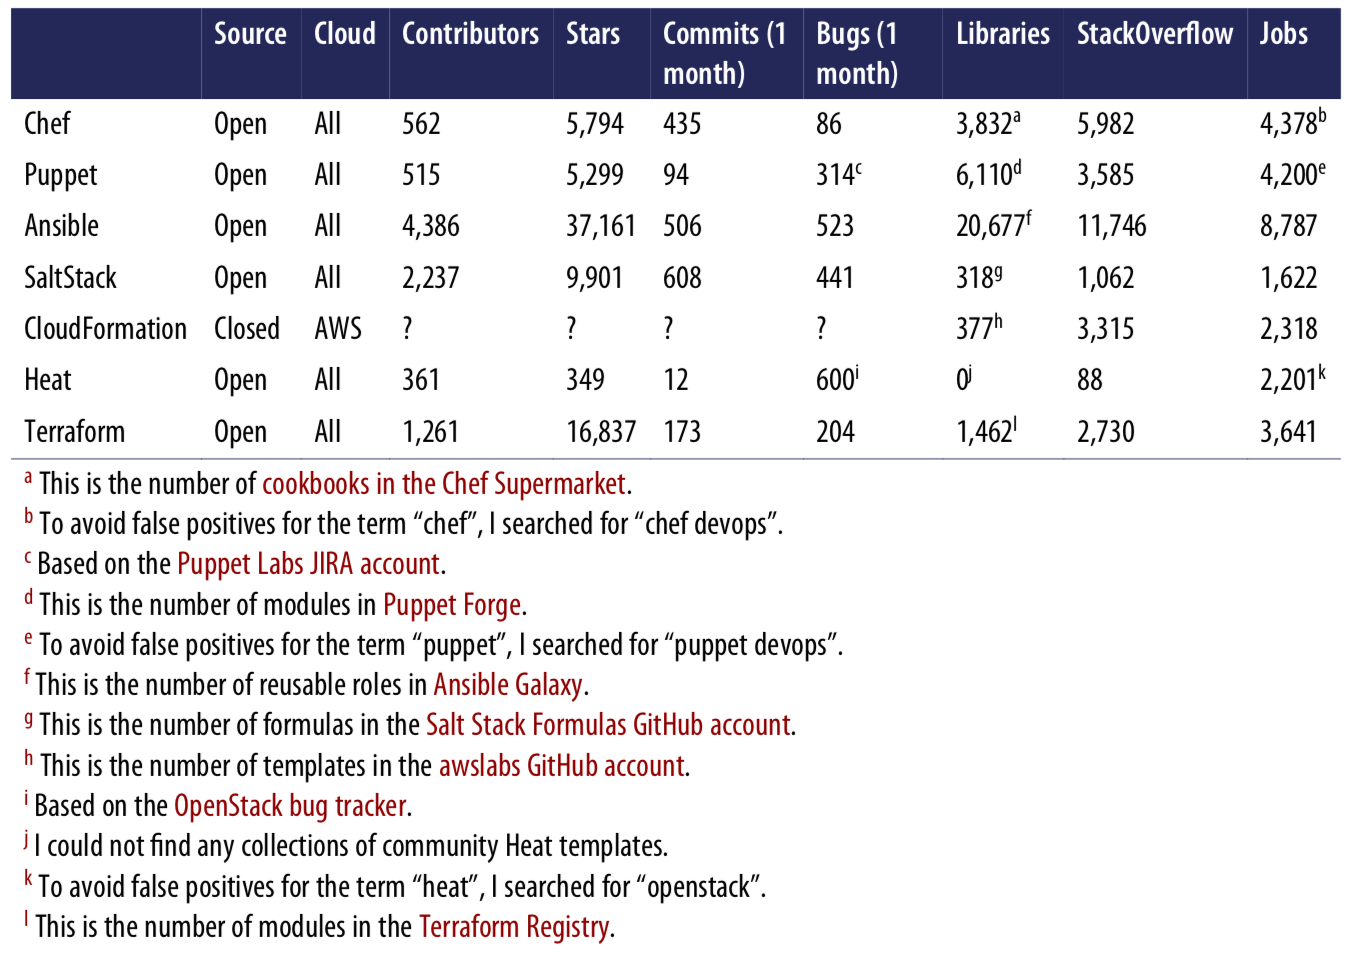

All of the IAC tools in this comparison are open source and work with many cloud providers, except for CloudFormation, which is closed source, and only works with AWS. Second, **Ansible** leads the pack in terms of popularity, with **Salt** and **Terraform** not too far behind.

Another interesting trend to note is how these numbers have changed over a time period of 2-3 years:

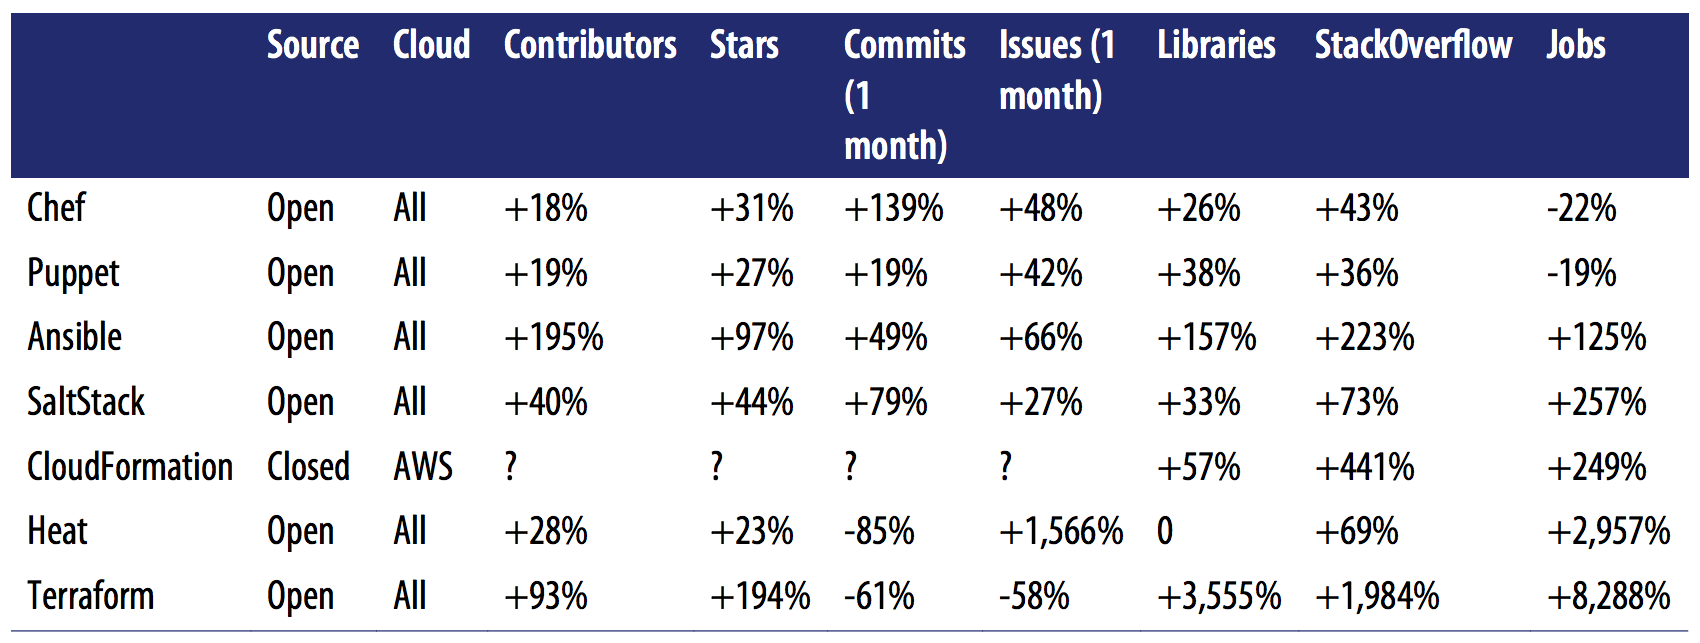

## <font color='blue'> Mature Versus Cutting Edge </font>

Another key factor to consider when picking any technology is maturity. The table below shows the initial release dates and current version number (as of May, 2019) for of each of the IaC tools.

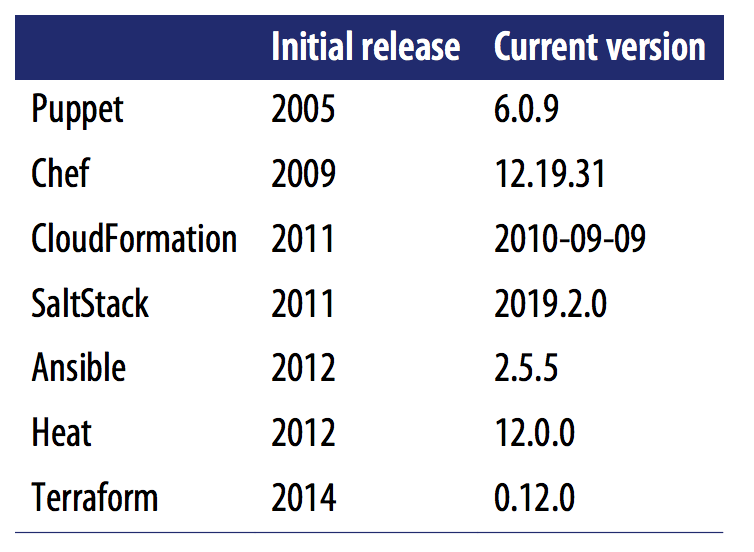
**Terraform** is, by far, the youngest IaC tool in this comparison. It’s still pre 1.0.0, so there is no guarantee of a stable or backward compatible API, and bugs are relatively common (although most of them are minor). 

This is **Terraform**’s biggest weakness: although it has gotten extremely popular in a short time, the price one pays for using this new, cutting-edge tool is that it is not as mature as some of the other IaC options.

## <font color='blue'> Using Multiple Tools Together </font>

Here are three common combinations thjat seem to work well at a number of companies:

* **Provisioning + Configuration Management**: Example - **Terraform** and **Ansible**.
* **Provisioning + Server Templating**: Example - **Terraform** and **Packer**.
* **Provisioning + Server Templating + Orchestration**: Example: **Terraform**, **Packer**, **Docker**, and **Kubernetes**.

## <font color='blue'> Conclusion </font>

Putting it all together, the table below shows how the most popular IaC tools stack up. This table shows the default or most common way the various IaC tools are used, though as discussed earlier, these IaC tools are flexible enough to be used in other configurations too. 

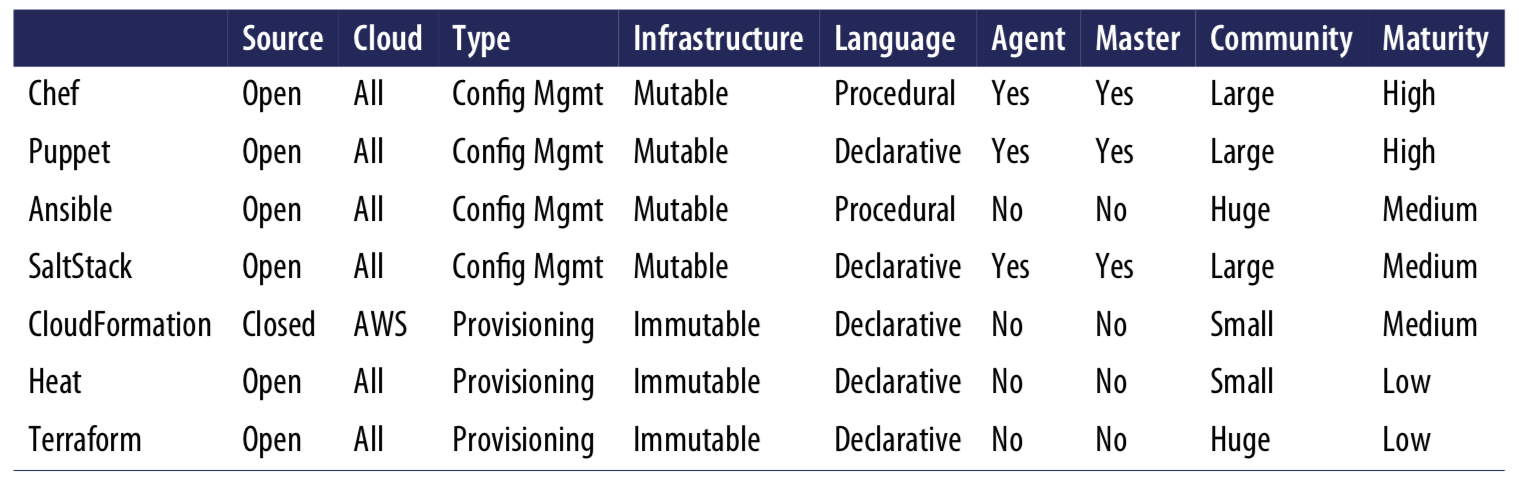

## <font color='blue'> References </font>

1. Why we use Terraform and not Chef, Puppet, Ansible, SaltStack, or CloudFormation: Gruntwork Blog - [https://blog.gruntwork.io/why-we-use-terraform-and-not-chef-puppet-ansible-saltstack-or-cloudformation-7989dad2865c](https://blog.gruntwork.io/why-we-use-terraform-and-not-chef-puppet-ansible-saltstack-or-cloudformation-7989dad2865c)
2. Image: Popularity of various IaC tools vis-a-vis Terraform - [https://miro.medium.com/max/2740/1*7LsMrODw5XIZmupadZ9U1w.png](https://miro.medium.com/max/2740/1*7LsMrODw5XIZmupadZ9U1w.png)
3. Image: IaC Tools Adoption Trends - [https://miro.medium.com/max/3400/1*oiuMLyJEGMLJRU4o0xp7fw.png](https://miro.medium.com/max/3400/1*oiuMLyJEGMLJRU4o0xp7fw.png)
4. Image: IaC Tools Usage Patterns - [https://miro.medium.com/max/3038/1*VDiEQvt_5WpywOY22WW6dw.png](https://miro.medium.com/max/3038/1*VDiEQvt_5WpywOY22WW6dw.png)